In [1]:
# Header cell
from __future__ import division
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

# Specific things needed
import time
import math
import sys

# Add parent directory to path
sys.path.append('../code/')
sys.path.append('../sim/')

# Import deft modules
import deft_1d
import simulate_data_1d
import utils

In [2]:
# Simulate data
N = 300
data_type = 'wide'

# Simulate data and get default deft settings
data, defaults = simulate_data_1d.run(data_type,N)

In [3]:
# Deft parameter settings
G = 200
alpha = 3
bbox = [-10,10]

# Do density estimation
results = deft_1d.run(data, G=G, alpha=alpha, \
    bbox=bbox, 
    periodic=False,
    num_samples=0,
    print_t=False,
    tollerance=1E-3)

In [4]:
# Compute true density
xs = results.bin_centers
Q_true = np.zeros(G)
for i, x in enumerate(xs):
    Q_true[i] = eval(defaults['pdf_py'])
Q_true /= results.h*sum(Q_true)

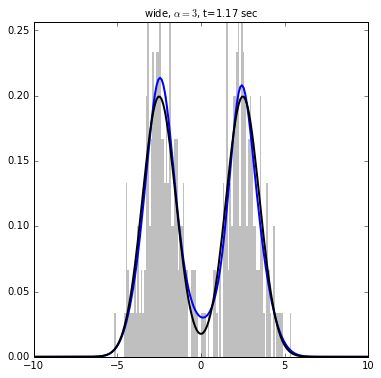

In [5]:
# Plot density estimate

# Make figure and set axis
plt.figure(figsize=[6, 6])
ax = plt.subplot(1,1,1)

# Plot histogram density
left_bin_edges = results.bin_edges[:-1]
plt.bar(left_bin_edges, results.R, \
    width=results.h, linewidth=0, color='gray', zorder=0, alpha=0.5)

# Plot deft density estimate
plt.plot(xs, results.Q_star, \
    color='blue', linewidth=2, alpha=1, zorder=2)

# Plot the true density
plt.plot(xs, Q_true, color='black', linewidth=2)

# Tidy up the plot
#plt.yticks([])
plt.ylim([0, 1.2*max(results.Q_star)])
plt.xlim(results.bbox)
t = results.deft_1d_compute_time
plt.title("%s, $\\alpha = %d$, t=%1.2f sec"%(data_type, alpha, t), \
    fontsize=10)

# Save plot
plt.savefig('report.test_deft_1d.png')

Something is wrong. This distribution is clearly biomodal. I think the regularization I'm using isn't properly implemented when computing the evidence ratio. 

In [6]:
# Derivative operator
L = results.G*results.h
h = L/G
delta_alpha_unitless=results.Delta.get_sparse_matrix()
delta_alpha=delta_alpha_unitless/(h**(2*alpha))  # Give delta unites
Q_star = results.Q_star
phi_star = -np.log(Q_star) - np.log(L)
t_star = results.t_star
l_star = results.l_star 
PHI_STD_REG = utils.PHI_STD_REG
hessian = (h*l_star**(2*alpha)/L)*delta_alpha + (h*N/L)*np.diag(np.exp(-phi_star)) + (N/G)*np.eye(G)/(N*PHI_STD_REG**2) 

# Compute spectrum
Q=np.linalg.eig(hessian)
e_vals = Q[0]
e_vecs = Q[1]

# Reorder eigenvalues and eigenvectors from smallest to largest
indices = np.argsort(e_vals)
e_vals = e_vals[indices]
e_vecs = e_vecs[:,indices]

In [7]:
# Define actions
def S(x):
    x=np.mat(np.ravel(x))
    return (h*l_star**(2*alpha)/(2*L))*(x*delta_alpha*x.T)[0,0] \
            + (h*N*np.mat(results.R)*x.T)[0,0] \
            + (h*N/L)*np.sum(np.exp(-x)) \
            + (N/G)*0.5*(x*x.T)[0,0]/(N*PHI_STD_REG**2)
    
# Define Laplacian action
def S_lap(x):
    x = np.mat(np.ravel(x))
    return 0.5*((x - phi_star) * hessian * (x - phi_star).T)[0,0]

# Define correction action
def S_cor(phi_star,dphi):
    x_star = np.ravel(phi_star)
    dx = np.ravel(dphi)
    return (h*N/L)*np.sum(np.exp(-x_star)*(np.exp(-dx) - 1 + dx - (dx**2)/2.0))

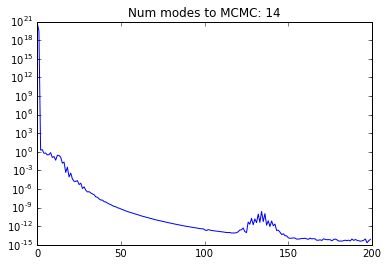

In [8]:
# Compute list of modes to MCMC
z = 3.0
T_max = 0.1
Ts = np.zeros(G)
S0 = S(phi_star)
for g in range(G):
    e_vec = np.ravel(e_vecs[:,g])
    e_val = e_vals[g]
    dphi = z*e_vec/np.sqrt(e_val)
    T_right = S_cor(phi_star,dphi)
    T_left = S_cor(phi_star,-dphi)
    Ts[g] = max(abs(T_right),abs(T_left))
    
modes = Ts > T_max 
plt.semilogy(Ts)
plt.title('Num modes to MCMC: %d'%sum(modes))

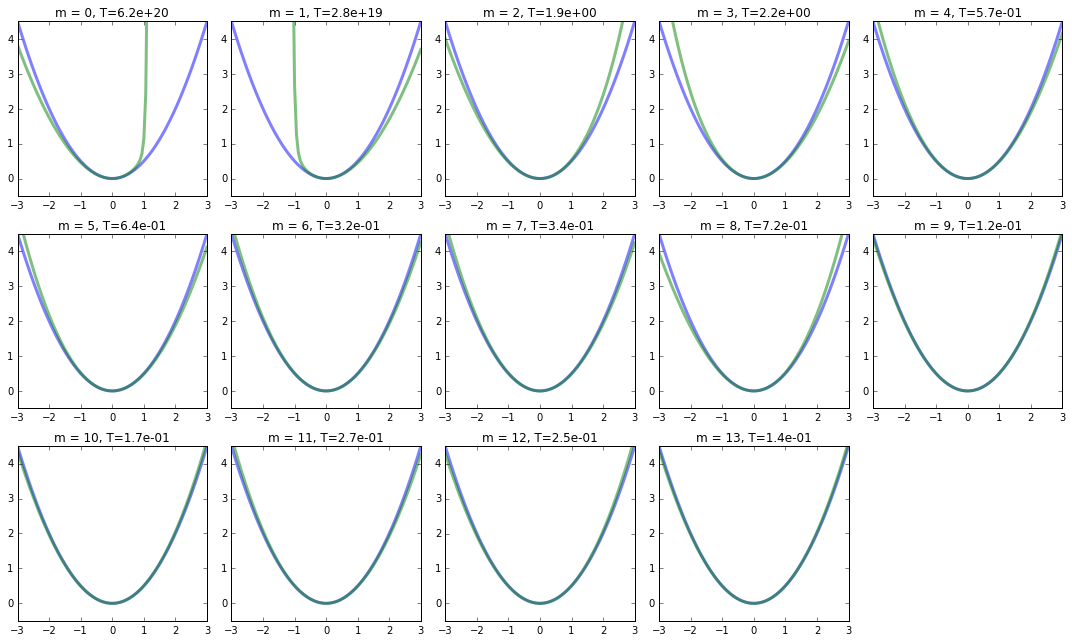

In [9]:
xs = np.linspace(-3,3,100)  # x-axis of plot
S0 = S(phi_star)
S0_lap = S_lap(phi_star)
num_modes = sum(modes)
num_cols = 5
num_rows = np.ceil(num_modes/num_cols)
gs = np.arange(G)[modes]

plt.figure(figsize=(3*num_cols,3*num_rows))
for m,g in enumerate(gs):
    plt.subplot(num_rows,num_cols,m+1)
    e_vec = e_vecs[:,g].T
    e_val = e_vals[g]
    v = e_vec / np.sqrt(e_val)   # direction of perturbation
    dSs_real = np.zeros(len(xs))
    dSs_lap = np.zeros(len(xs))
    for k,x in enumerate(xs):
        phi = phi_star + x*v
        dSs_real[k] = S(phi)-S0
        dSs_lap[k] = S_lap(phi)-S0_lap
    
    plt.plot(xs,dSs_lap,'b',linewidth=3,alpha=.5)
    plt.plot(xs,dSs_real,'g',linewidth=3,alpha=.5)
    plt.ylim([-0.5,max(dSs_lap)])
    plt.title('m = %d, T=%1.1e'%(m,Ts[g]))
plt.tight_layout()
plt.show()

In [10]:
# Draw phi from laplace approximation
def laplace_phi(phi_star,e_vals,e_vecs):
    G,K = e_vecs.shape
    assert len(phi_star)==G
    assert len(e_vals)==K
    
    # Build up phi
    phi = np.ravel(phi_star.copy())
    for k in range(K):
        phi += np.random.randn()*np.ravel(e_vecs[:,k])/np.sqrt(e_vals[k])
        
    return phi

# Add Laplace approx phis to MCMC sampled phis
def add_laplace_to_mcmc(mcmc_phis,lap_e_vals,lap_e_vecs):
    G,N = mcmc_phis.shape
    K = len(lap_e_vals)
    assert lap_e_vecs.shape == (G,K)
    phis_new = mcmc_phis.copy()
    
    for n in range(N):
        for k in range(K):
            phis_new[:,n] += np.random.randn()*np.ravel(lap_e_vecs[:,k])/np.sqrt(lap_e_vals[k])
    return phis_new
        

In [11]:
# Convert phis to Qs
def phis_to_Qs(phis,h):
    G,N = phis.shape
    Qs = np.zeros([G,N])
    for n in range(N):
        phi = np.ravel(phis[:,n].copy())
        Qs[:,n] = np.exp(-phi)/np.sum(h*np.exp(-phi))
    return Qs

# Compute entropies
def Qs_to_entropies(Qs,h):
    N = Qs.shape[1]
    entropies = np.zeros(N)
    for n in range(Qs.shape[1]):
        Q = np.ravel(Qs[:,n].copy())
        entropies[n] = -np.sum(h*Q*np.log(Q+1E-10))
    return entropies

In [12]:
# Function to do MCMC sampling
def mcmc(num_steps, action, phi0, e_vals, e_vecs, record_every = 1, tol=1E-6):
    
    # Get dimensions
    G = e_vecs.shape[0]
    K = e_vecs.shape[1]
    assert K <= G, 'G == %d, K == %d'%(G,K)
    
    # Make sure there are the proper number of eigenvalues
    assert len(e_vals) == K
    
    # Make sure e_vecs are normalized eigenvectors
    assert e_vecs.shape[0] == G
    for g in range(K):
        e_vec = np.mat(e_vecs[:,g])
        dot = (e_vec.T*e_vec)[0,0]
        assert abs(dot-1.0) < tol, 'v.T*v == %f'%dot
    
    # Reshape phi
    assert len(phi0) == G
    
    # Initialize phi_current
    phi_current = np.ravel(phi0.copy())
    
    # Reserve memory for samples
    num_samples = int(np.floor((num_steps-1)/record_every))+1
    phis_sampled = np.zeros([G,num_samples])
    action_values = np.zeros(num_samples)
    
    # Do MCMC loop
    acceptances = 0
    for n in range(num_steps):
        
        # Choose mode 
        g=np.random.randint(0,K)
        e_vec = np.ravel(e_vecs[:,g])    
        e_val = e_vals[g]
        
        # Choose step
        step_length = np.random.normal(0,1.0)
        step_vector = (step_length/np.sqrt(e_val)) * e_vec
        phi_new = phi_current + step_vector
        
        # Accept or reject
        u = np.random.uniform(0,1)
        if u < np.exp(action(phi_current)-action(phi_new)): 
            phi_current = phi_new
            acceptances += 1
            
        # Record acceptance if want to
        if n%record_every == 0:
            sample_num = n/record_every
            phis_sampled[:,sample_num] = phi_current
            action_values = action(phi_current)
            
    # Report acceptance
    print 'Acceptance rate = %0.1f%%'%(100.*acceptances/num_steps)
        
    # Return sampled phis
    return phis_sampled

In [13]:
# Track convergence of samples
num_chains=10
num_steps=1000
record_every = sum(modes)
K = sum(modes)
num_samples = int(np.floor((num_steps-1)/record_every)+1)

# Run MCMC and compute chains
mcmc_e_vals = e_vals[modes]
mcmc_e_vecs = e_vecs[:,modes]
lap_e_vals = e_vals[~modes]
lap_e_vecs = e_vecs[:,~modes]

entropies = np.zeros([num_samples,num_chains])
Ts = np.zeros([num_samples,num_chains])

mcmc_phis = np.zeros([G,num_samples])
phis = np.zeros([G,num_samples])

for m in range(num_chains):
    
    # Use Laplace approximation to set initial phi
    #phi0 = laplace_phi(phi_star,e_vals,e_vecs)

    # Do MCMC sampling
    mcmc_phis = mcmc(num_steps, S, phi_star, mcmc_e_vals, mcmc_e_vecs, record_every)
    
    # Add Laplace components
    phis = add_laplace_to_mcmc(mcmc_phis,lap_e_vals,lap_e_vecs)
    
    # Compute weights
    for n in range(num_samples):
        dphi = np.ravel(phis[:,n])-np.ravel(phi_star)
        mcmc_dphi = np.ravel(mcmc_phis[:,n])-np.ravel(phi_star)
        Ts[n,m] = S_cor(phi_star,dphi) - S_cor(phi_star,mcmc_dphi)
    
    # Comptue entropies
    Qs = phis_to_Qs(phis,h)
    entropies[:,m] = Qs_to_entropies(Qs,h)
    
# Compute weights
weights = np.exp(-Ts)

/Users/jkinney/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Acceptance rate = 72.8%
Acceptance rate = 70.9%
Acceptance rate = 67.9%
Acceptance rate = 68.1%
Acceptance rate = 71.7%
Acceptance rate = 72.7%
Acceptance rate = 69.7%
Acceptance rate = 66.5%
Acceptance rate = 68.6%
Acceptance rate = 68.8%


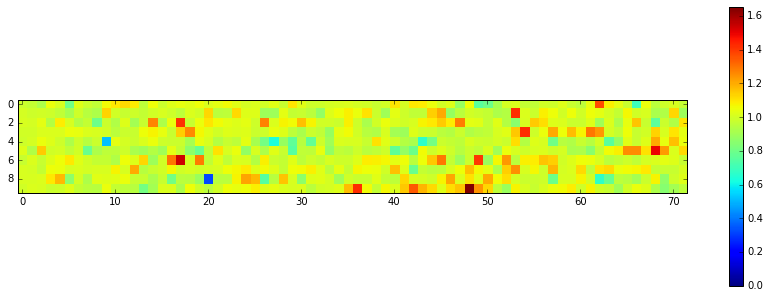

In [14]:
plt.figure(figsize=(15,5))
plt.imshow(weights.T,interpolation='nearest',vmin=0)
plt.colorbar()

2.10480480683


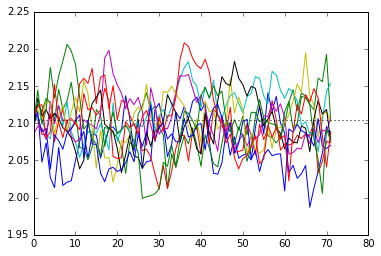

In [15]:
entropy_star = Qs_to_entropies(np.mat(Q_star).T,h)[0]
print entropy_star

# Plot chains
sample_nums = range(num_samples)
ax = plt.plot(entropies)
plt.axhline(entropy_star,linestyle=':',color='k')
    

In [16]:
print np.mean(entropies,axis=0)
print np.var(entropies,axis=0)

[ 2.07461658  2.09760423  2.09085091  2.11696332  2.10629545  2.10622899
  2.09977723  2.07715355  2.09768106  2.10592189]
[ 0.00130595  0.00111932  0.00119309  0.00086358  0.00095825  0.00098416
  0.00104139  0.00063812  0.00201872  0.00158803]


/Users/jkinney/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Acceptance rate = 68.6%
Acceptance rate = 69.3%


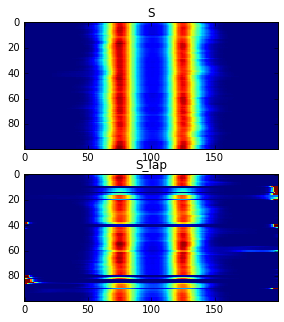

In [17]:
# MCMC sampling for S
# K is no. of metropolis iterations
num_steps=1000
num_modes=10
record_every = num_modes

# MCMC sampling for S
phis = mcmc(num_steps, S, phi_star, e_vals[:num_modes], e_vecs[:,:num_modes], record_every)
Qs = phis_to_Qs(phis,h)

# MCMC sampling for S_lap
phis_lap = mcmc(num_steps, S_lap, phi_star, e_vals[:num_modes], e_vecs[:,:num_modes], record_every)
Qs_lap = phis_to_Qs(phis_lap,h)

# Plot results
plt.figure(figsize=[5,5])

# Plot Qs for true action
plt.subplot(211)
plt.imshow(Qs.T,interpolation='nearest')
plt.title('S')

# Plot Qs for Laplace action
plt.subplot(212)
vmax = max(np.ravel(Qs))
plt.imshow(Qs_lap.T,interpolation='nearest',vmax=vmax, vmin=0)
plt.title('S_lap')